Num_etu :71604573

Nom : DUONG

Prénom : Duc Nguyen

======

Num_etu :71500267 

Nom : BOUSAHIH 

Prénom : Mohamed-Amine

# Homework 2

To be done in groups of 2 students.

# Pricing Diamonds


The dataset contains the following features.
- price : price of the dimaond in dollars.

- carat : weight of the diamond

- cut : quality of the cut

- color : color of the diamond, J (worst) to D (best)

- clarity : I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)

- x : length (mm) 

- y :  width (mm) 

- z : depth (mm) 

- depth : 2 * z / (x + y)

- table :  width of top of diamond relative to widest point



## Your job

- Try to understand the data, visualize it. You may use unsupervised learning methods at this stage.
- The main aim is then to predict, using supervised learning methods, the price of diamonds based on their different quality features.

## We want to see the following things

- Prediction results and mean squared error obtained on the test set for the methods you considered.
- A discussion about the impact of the hyperparameters of the methods on your predictions.
- A clear comparison between your solutions (a table, and/or plots comparing the results obtained with different methods).
- A discussion about the difficulties encountered if applicable.
- You'll get a good grade if you reach a good accuracy **and** if your notebook is clean, with clear graphs and explanations of what you did **and** if you did efficient calibration of the methods and serious comparisons between different methods
- You will send your notebook **containing** the results (**WE WON'T RUN YOUR NOTEBOOK**), namely with the graphs and results that you want to show, as a **unique** jupyter notebook file (`.ipynb` extension). We won't open any other supplementary file.

## Hand in your assignment  before 15/11/20 23h55 :

- via Moodle for all Université de Paris students
- via email if Moodle not possible for Paris 1 students, subject [Machine Learning DM2], aurelie.fischer@univ-paris-diderot.fr


## Example of methods

Unsupervised learning methods and visualization :
- PCA
- k-means
- mixture models
- spectral clustering
...

Supervised learning methods :
- discriminant analysis
- logistic regression
- SVM
- regression trees
- bagging
- random forests
- boosting
- ...

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from prettytable import PrettyTable
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import linalg
import itertools
import matplotlib as mpl
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# Data preparation

## Data understanding

In [4]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/diamonds.csv')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


The column Unnamed: 0 seems to be not necessary so we are going to drop it.

price is of type int64, we might want to use the same type for all numerical features (float here).

In [6]:
data = data.drop(['Unnamed: 0'],axis = 1)

data["price"] = data["price"].astype(float)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75


In [7]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

There are 53490 instances in the dataset. There are also no missing instances in the dataset. That looks pretty clean!

It's a must to work with dataset when all its features are numerical. The cut, color and clarity features are non-numeric (They are objects). We need to convert them to numerical.

Let's have a closer look!

In [8]:
data["cut"].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [9]:
data["clarity"].value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

In [10]:
data["color"].value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

We can see here that they don't have many categories.

Let's have a global view to our numerical features with a quick summary

In [11]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Remove outliers

We can see in the summary that there are somes x,y,z features equal to 0. It doesn't make any sense, so let's drop them.

In [12]:
#We have some x,y,z = 0. It doesn't make any sense, so let's drop them
data = data.loc[(data[['x','y','z']]!=0).all(axis=1)]
data.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [13]:
data.loc[(data['x']==0) | (data['y']==0) | (data['z']==0)].shape

(0, 10)

We can see there are some outliers out there. For example, we have the max carat = 5.01 but 75% of diamonds carat is lower than 1.04, or the max y dimension is 58.9 but 75% of diamonds y dimension is lower than  6.54, ...

Let's have a closer look to theses outliers with a boxplot.

In [14]:
def box_plot(data, num_features):
    fig, axes = plt.subplots(nrows=1, ncols=len(num_features), figsize=(22, 3))
    c=0
    for ax in axes:
        data.boxplot(column=num_features[c], ax=axes[c])
        plt.xlabel(num_features[c])
        c = c+1
    plt.show()

In [15]:
numerical_features = data.select_dtypes(include=[np.number]).columns

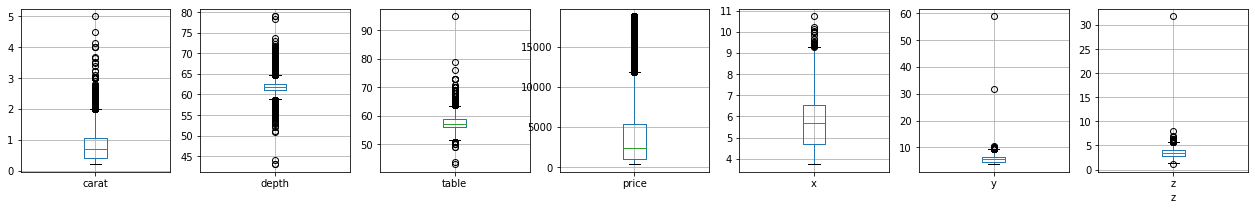

In [16]:
box_plot(data,numerical_features)

Yes, definitely, there are some outliers that we need to remove

We will remove outliers by calculating z-score which is equals to (Observation — Mean)/Standard Deviation :

$$z_{score} = \frac{(X - \mu)}{\sigma}$$

We find the z score for each of the data point in the dataset and if the z score is greater than 2 than we can classify that point as an outlier.

In [17]:
def remove_outliers(data, l, z):
    for var in l:
        result = data[np.abs(stats.zscore(data[var])) < z]
    return result
  
data = remove_outliers(data, numerical_features,2)

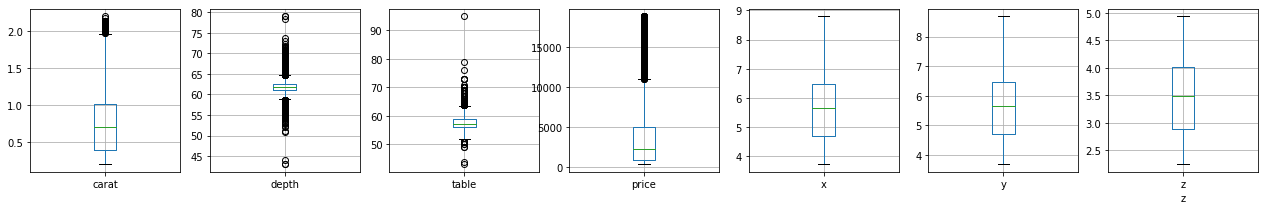

In [18]:
box_plot(data,numerical_features)

That looks much more clean now !

## Convert data to log scale

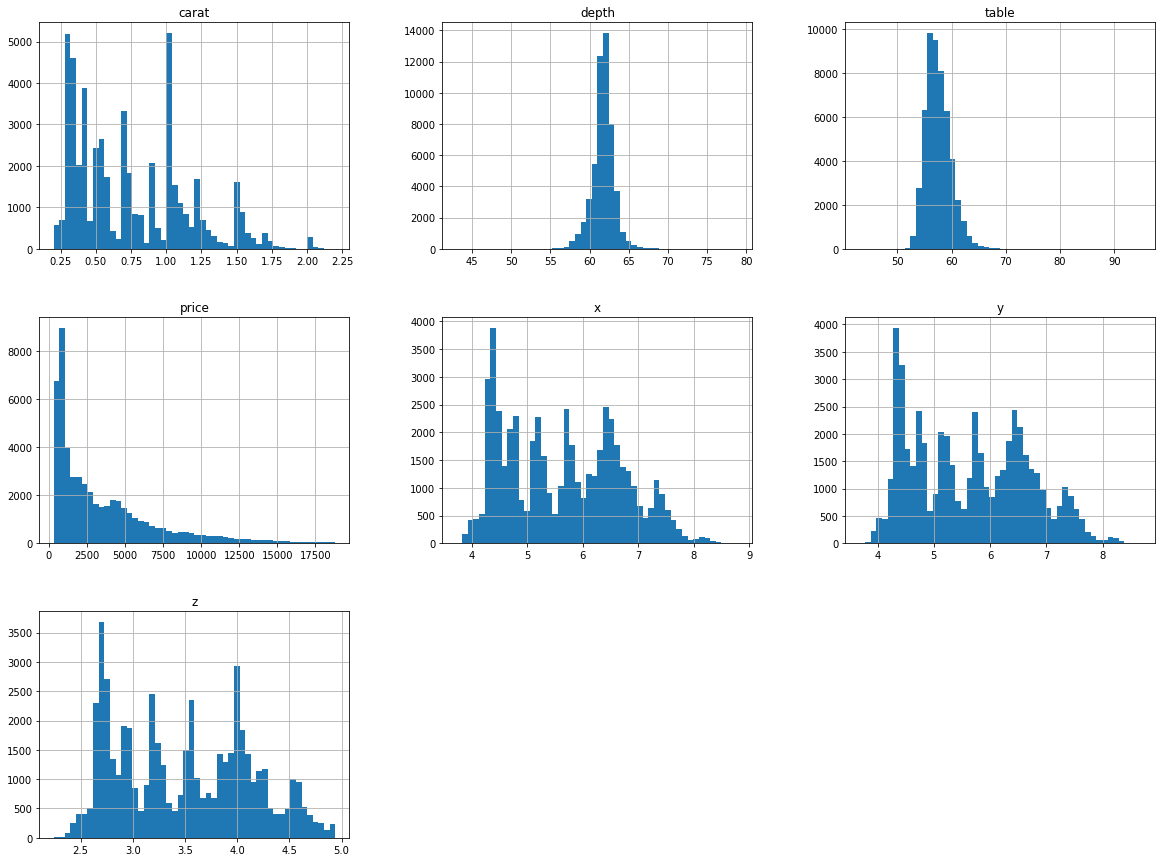

In [19]:
data.hist(bins = 50, figsize = (20, 15))
plt.show()

We see that most features are not normally distributed, but one of the most favored approach, if not a prerequisite, is to use Gaussian distributed data. That will help us to have  better predictions

So we will log convert our numerical features to have Gaussian distributed data.

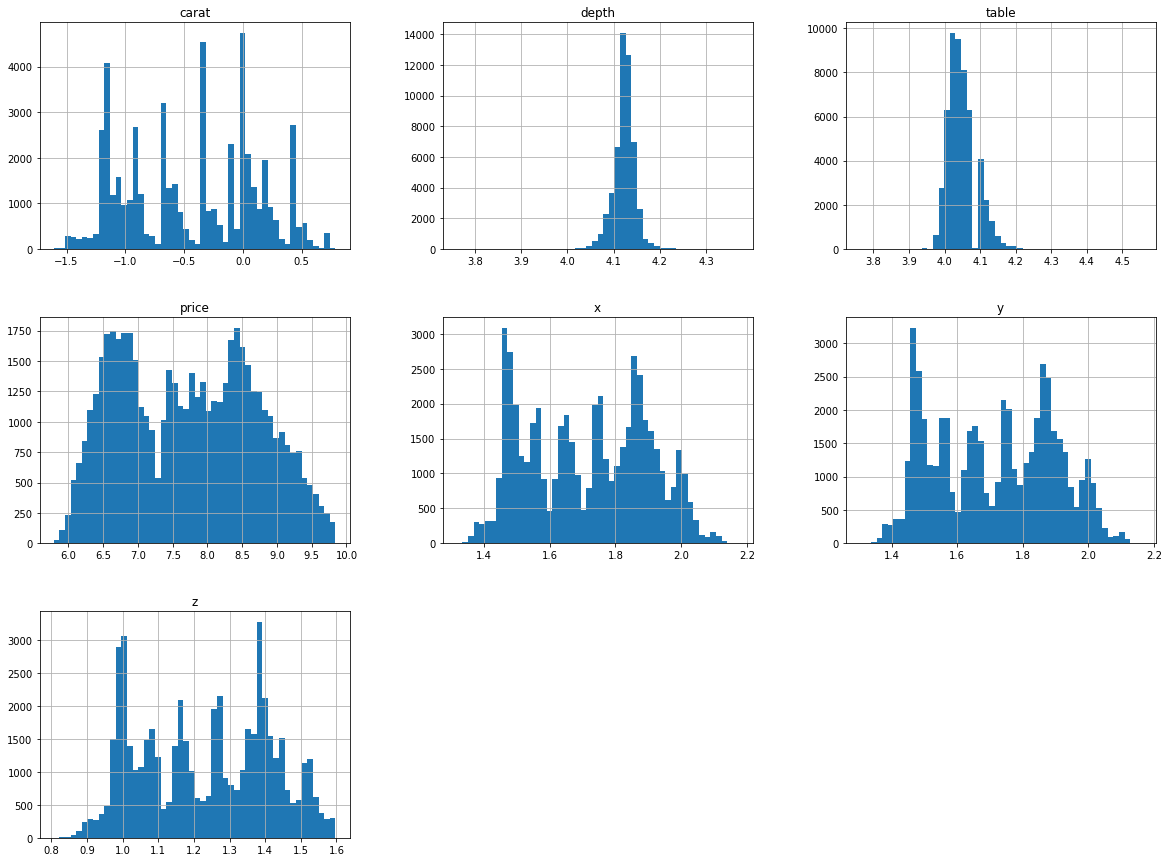

In [20]:
# this log converts dataframe's features inplace
def log_convert(data, numerical_features):
    for feature in numerical_features:
        data[feature] = np.log(data[feature])

numerical_features = list(data.drop(['color','cut','clarity'],axis = 1))
log_convert(data,numerical_features)
data.hist(bins = 50, figsize = (20, 15))
plt.show()

Here, we can see theses distributions are mixted gaussian distributions.

## Split dataset into train dataset and test dataset

To train and test our models, we need to split dataset into train dataset and test dataset.

The idea is pretty clear but it just feels not right to randomly split our dataset, else we could introduce a significant sampling bias. What we want to have is a test dataset which is representative of the overall dataset.

To do that, one great way is to perform Stratified Sampling. The dataset will be divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum.

To use that, we need a very important feature to predict the price.

So let's see what is the feature most correlated to the price.

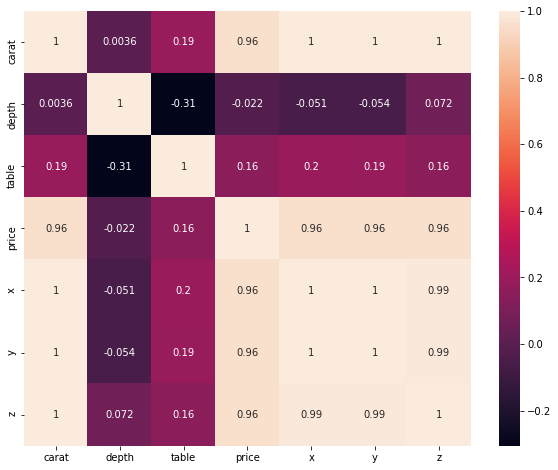

In [21]:
# Create a correlation matrix between every pair of attributes
corr_matrix = data.corr()

# Plot the correlation with seaborn
plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True)
plt.show()

We see that carat is the feature most correlated with the price. And x,y,z dimension are highly correlated with carat which is normal because the weight of the diamond depends on its size.

So we will use carat for our Stratified Sampling.

For that, we need to divided carat features into classes.

We might want use a gaussian mixture models to classify carat since we are log convert it to have Gaussian distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22b74b09b0>,
      dtype=object)

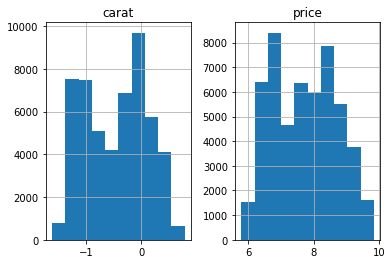

In [22]:
data[['carat','price']].hist()

In [23]:
X = np.array(data[['carat','price']])

In [24]:
# I just take your function to find the best number of cluster here. 
def best_GM(X):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)



    color_iter = itertools.cycle(['lightcoral', 'lightseagreen', 'gold','limegreen'])

    rb = plt.get_cmap('rainbow')
    colors = rb(np.linspace(0, 1.0, len(n_components_range)))
    clf = best_gmm
    bars = []

    # Barplot of BIC scores

    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the best model
    splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,colors)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title('Best model')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()
    return clf

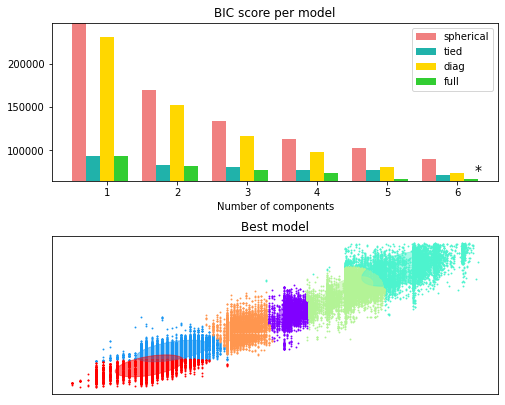

In [25]:
gaussian_classifier = best_GM(X)

So here, we will class carat feature into 6 classes.

In [26]:
data["carat_cat"] = gaussian_classifier.predict(data[["carat","price"]])

In [27]:
data["carat_cat"].value_counts()

3    13628
1    10339
4     7387
5     7190
2     7115
0     6435
Name: carat_cat, dtype: int64

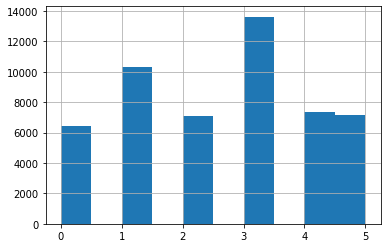

In [28]:
data["carat_cat"].hist()
plt.show()

The classification looks pretty clean! 

In [29]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
0,-1.469676,Ideal,E,SI2,4.119037,4.007333,5.786897,1.373716,1.381282,0.887891,5
1,-1.560648,Premium,E,SI1,4.091006,4.110874,5.786897,1.358409,1.345472,0.837248,5
2,-1.469676,Good,E,VS1,4.041295,4.174387,5.789960,1.398717,1.403643,0.837248,5
3,-1.237874,Premium,I,VS2,4.133565,4.060443,5.811141,1.435085,1.442202,0.966984,5
4,-1.171183,Good,J,SI2,4.147885,4.060443,5.814131,1.467874,1.470176,1.011601,5


In [30]:
# Run the split. Creates on split and shares 20% of the dataset for the test set
split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

# Separate the stratified train set and the test set
for train_index, test_index in split.split(data, data["carat_cat"]):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

Let's do a PCA to see if we can drop some columns before fitting our models.

In [31]:
numerical_features

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

[0.71017986 0.18404743 0.09741395]


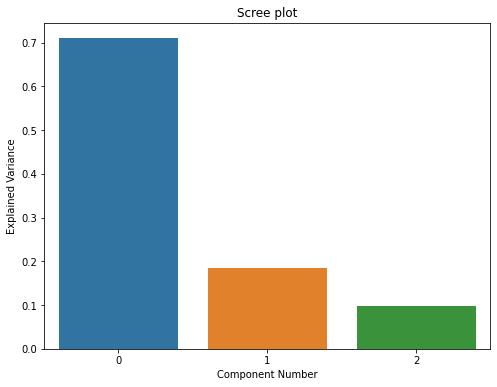

In [32]:
n_components = 3
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_features])
pca = PCA(n_components=n_components)
pca.fit(scaled_data)
print(pca.explained_variance_ratio_)
# Do a scree plot
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.barplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

The "coude" criterion as well as that of the "Scree-test" lead us to retain the first two axes. Indeed, the first axis retains 71% of the total inertia while axis 2 still retains 18% of the inertia, which is not negligible. This leads to an explained inertia rate of 89%, which is a good result.

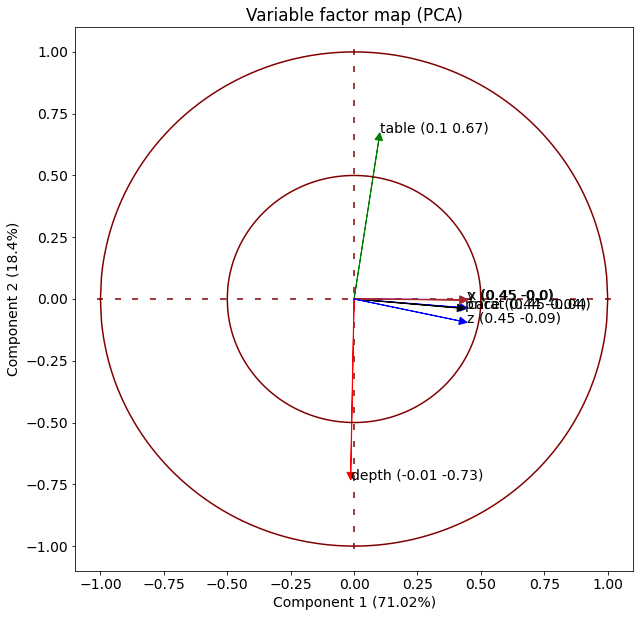

In [33]:
pca_values=pca.components_

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
#Plot circle#Create a list of 500 points with equal spacing between -1 and 1import numpy as np
x=np.linspace(start=-1,stop=1,num=500)#Find y1 and y2 for these points
y_positive=lambda x: np.sqrt(1-x**2) 
y_negative=lambda x: -np.sqrt(1-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')
#Plot smaller circle
x=np.linspace(start=-0.5,stop=0.5,num=500)
y_positive=lambda x: np.sqrt(0.5**2-x**2) 
y_negative=lambda x: -np.sqrt(0.5**2-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')
#Create broken lines
x=np.linspace(start=-1,stop=1,num=30)
plt.scatter(x,[0]*len(x), marker='_',color='maroon')
plt.scatter([0]*len(x), x, marker='|',color='maroon')
#Define color list
colors = ['blue', 'red', 'green', 'black', 'purple', 'brown']
if len(pca_values[0]) > 6:
    colors=colors*(int(len(pca_values[0])/6)+1)
add_string=""
for i in range(len(pca_values[0])):
    xi=pca_values[0][i]
    yi=pca_values[1][i]
    plt.arrow(0,0, 
              dx=xi, dy=yi, 
              head_width=0.03, head_length=0.03, 
              color=colors[i], length_includes_head=True)    
    add_string=f" ({round(xi,2)} {round(yi,2)})"
    plt.text(pca_values[0, i], 
             pca_values[1, i] , 
             s=numerical_features[i] + add_string )
plt.xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
plt.ylabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
plt.title('Variable factor map (PCA)')
plt.show()

The variables x, y, z, carat and price are strongly correlated. They are positively correlated with PC1. This axis PC1 attracts our attention for this project. This axis represent a large part of the data that we want explained.

The depth and table variables are negatively decorrelated because they are opposite. When the depth of a diamond is high, the table variable becomes low. The impact of these variables for predicting the price of diamonds is extremely minimal. This will allow us not to consider these variables when setting up our models.

So we are going to drop table and depth columns, we believe that they have a negligable impact to the price.

In [34]:
for set in (strat_train_set, strat_test_set):
    set.drop(["carat_cat","depth","table"], axis = 1, inplace = True)

In [35]:
X_train = strat_train_set.drop('price',axis = 1)
Y_train = strat_train_set['price']

X_test = strat_test_set.drop('price',axis = 1)
Y_test = strat_test_set['price']

print('X_train shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('Y_train shape :',Y_train.shape)
print('Y_test shape :',Y_test.shape)

X_train shape : (41675, 7)
X_test shape : (10419, 7)
Y_train shape : (41675,)
Y_test shape : (10419,)


In [36]:
X_train.head()

,carat,cut,color,clarity,x,y,z
38105,-1.021651,Premium,E,VS2,1.523880,1.517323,1.015231
37982,-0.941609,Ideal,G,VS1,1.539015,1.545433,1.075002
400,-1.203973,Good,H,SI1,1.449269,1.435085,0.993252
50135,-0.328504,Premium,G,SI1,1.749200,1.743969,1.255616
12962,0.000000,Very Good,D,SI1,1.840550,1.843719,1.366092


## Features scaling and categorical features handling

We still need to do something with categorical features since machine learning methodes only take numerical inputs.

What we might want to do is convert theses categorical features to one hot vector.



In [37]:
categorical_features = ["cut","clarity","color"]
numerical_features = list(X_train.drop(categorical_features,axis = 1))
print(categorical_features)
print(numerical_features)

['cut', 'clarity', 'color']
['carat', 'x', 'y', 'z']


We will create a pipeline to scale our numerical features and transform our categorical features in the same time.

In [38]:
# Pipeline to transform our dataset
pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features), # Perform feaured scaling on numeric attributes
    ("cat", OneHotEncoder(), categorical_features) # Perform One-Hot encoding on the category attributes
])

In [39]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)

# Models

## Regression Metrics

Let’s be clear on how we would evaluate and compare different models. 

For that purpose, we will use theses metrics :

1. Mean absolute error: Mean Absolute Error refers to the mean of the absolute values of each prediction error on all instances of the dataset. The prediction error is the difference between the actual value and the predicted value for that instance.

$$ \frac{1}{N}\sum^N_{i=1} |y_i - \hat y_i|$$

2. Root mean squared error: It is the square root of the sum of the square of the difference between the predicted and actual target variables, divided by the number of data points. RMSE has the benefit of penalizing large errors more.

$$ \sqrt{\frac{1}{N}\sum^N_{i=1} (y_i - \hat y_i)^2}$$

3. R-squared score: The R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data. 

$$ 1 - \frac{\sum^N_{i=1} (y_i - \hat y_i)^2}{\sum^N_{i=1} (y_i - \bar y_i)^2}$$



## Commun functions

In [40]:
mae_list = []
rmse_list = []
rsquare_list = []
regressor = []

In [41]:

def display_model(model_name,model,
                  X_train = X_train, Y_train = Y_train,
                  X_test = X_test, Y_test = Y_test,
                  poly = None, save = True):
    

    #fit model
    if poly != None:
        X_train = poly.fit_transform(X_train)
        X_test = poly.fit_transform(X_test)
    model.fit(X_train,Y_train)

    #prediction
    Y_pred=model.predict(X_test)
    
    #Score
    print("====== Test Score ======")
    Rsquare=model.score(X_test,Y_test)
    print("Rsquare: %f" %(Rsquare))

    #reconvert to normal scale
    Y_pred = np.exp(Y_pred)
    Y_test = np.exp(Y_test)
    mae = metrics.mean_absolute_error(Y_test,Y_pred)
    print("mae: %f" %(mae))
    rmse=np.sqrt(metrics.mean_squared_error(Y_test,Y_pred))
    print("rmse: %f" %(rmse))

    #save
    if (save):
        regressor.append(model_name)
        rsquare_list.append(Rsquare)
        mae_list.append(mae)
        rmse_list.append(rmse)

    #plot 
    print("====== Test Prediction vs Actual ======")
    plt.scatter(Y_test, Y_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    plt.plot(x_lim, y_lim, "k--")
    plt.show()
    return Y_pred

In [42]:
def print_pred_true(Y_pred,Y_test):
    result = pd.DataFrame(data=np.exp(Y_pred), index=Y_test.index, columns=["predicted price"])
    result['price'] = np.exp(Y_test)
    result['diff'] = np.abs(result['predicted price'] - result['price'])
    return result

## Linear/Polynomial Regression

====== Test Score ======
Rsquare: 0.982129
mae: 349.451347
rmse: 632.639852
====== Test Prediction vs Actual ======


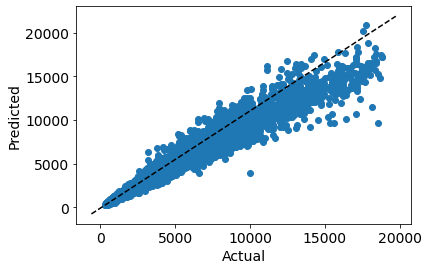

array([1205.79944931, 7026.1429917 ,  864.5309922 , ..., 9509.15490272,
        712.51338309,  555.49515563])

In [43]:
reg_linear=linear_model.LinearRegression()
display_model("Regression Lineaire",reg_linear)

====== Test Score ======
Rsquare: 0.981727
mae: 347.949461
rmse: 625.564081
====== Test Prediction vs Actual ======


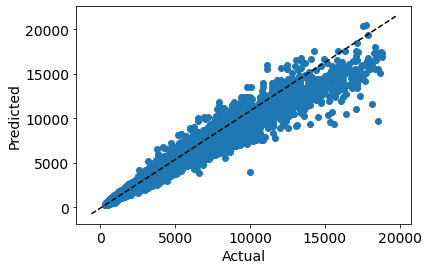

array([1207.03947556, 7117.02743383,  851.47253392, ..., 9447.66917751,
        723.30274427,  560.51214285])

In [44]:
ridge = linear_model.Ridge()
display_model("Ridge Regression",ridge)

====== Test Score ======
Rsquare: 0.987012
mae: 310.798893
rmse: 563.666583
====== Test Prediction vs Actual ======


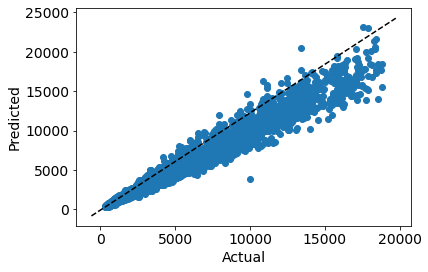

array([1190.2934792 , 6633.33319077,  819.43576191, ..., 9871.97607759,
        694.53044857,  551.51372297])

In [45]:
poly = PolynomialFeatures(degree = 2)
reg_poly_2 = linear_model.LinearRegression()
display_model("Polynomial regressor (degree 2)",reg_poly_2,poly=poly)

As we can see, linear and polynomial regressions work pretty well with R-squared score close to 98%. We have this efficiency because we log-transformed our dataset. If we didn't log-transform our data, it wouldn't work that well.

Furthermore, polynomial (degree 2) regression have a lower rmse than linear regression, which means it has less large errors than linear regression (so polynomial regression is a little bit better than linear regression).

## Decision Tree Regression

====== Test Score ======
Rsquare: 0.978619
mae: 388.913664
rmse: 741.338651
====== Test Prediction vs Actual ======


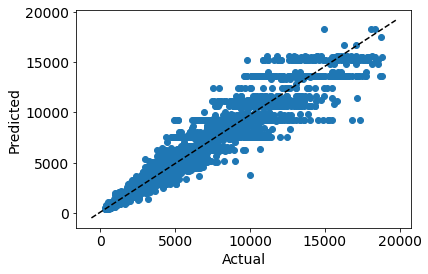

array([ 882.00627653, 5490.13803121,  883.21933158, ..., 9779.14701519,
        680.38413675,  549.11430119])

In [46]:
decision_tree = DecisionTreeRegressor(random_state=42,max_depth=10)
display_model("Decision tree regressor",decision_tree,save=False)

We can see here, a decision tree regressor which a max depth fixed to 10 is not good, it predicted the same price for different actual prices. So let nodes expanded until all leaves are pure or until all leaves contain less than min_samples_split samples (which means we don't precise max_depth parameter).

====== Test Score ======
Rsquare: 0.984384
mae: 315.731733
rmse: 614.760806
====== Test Prediction vs Actual ======


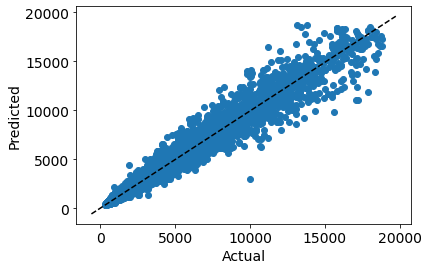

array([1200., 5808.,  868., ..., 9297.,  637.,  521.])

In [47]:
decision_tree = DecisionTreeRegressor(random_state = 42)
display_model("Decision tree regressor",decision_tree)

We can see here that decision tree regression works pretty well, which has a R_square score of 98% (works as well as linear regressions). 

## Support Vector Regression

====== Test Score ======
Rsquare: 0.982054
mae: 346.082772
rmse: 634.335456
====== Test Prediction vs Actual ======


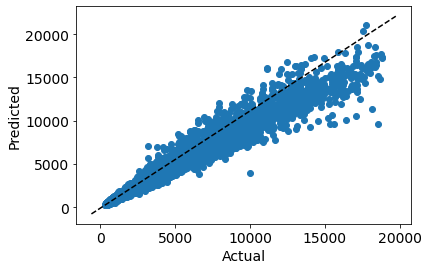

array([1181.20942288, 6917.73859794,  862.78720706, ..., 9489.30123992,
        691.02519991,  546.45214357])

In [48]:
svm_reg = LinearSVR()
display_model("SVR",svm_reg,save=False)

We found very close values of R_square, mae and rmse with others methods done before, with a r_squared of 98%. We can say that SVR works pretty good too.

## AdaBoost Regression

====== Test Score ======
Rsquare: 0.945421
mae: 675.569713
rmse: 1254.061159
====== Test Prediction vs Actual ======


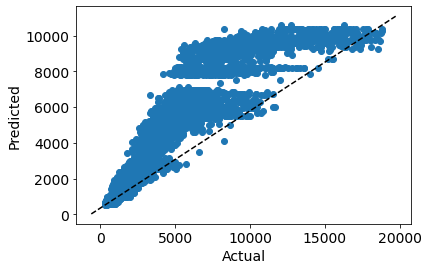

array([1133.99696917, 8525.10432237,  710.68407535, ..., 9699.50447379,
        913.6592831 ,  710.68407535])

In [49]:
ada = AdaBoostRegressor(random_state=0, n_estimators=200)
display_model("Ada boost regressor",ada)

We observe that adaboost regression is the worst method until now, even with 200 estimators, maybe because it use default estimator a decision tree with a depth of 3 (not deep enough).

## Random Forests Regression

We see that several methods like RandomForestRegressor, BaggingRegressor, GradientBoosting take several hyperparameters. 

If we use too 'low' parameters, we risk to not have the best version of our algorithms, if we use too 'high', it might use our computational resources unnecessary

In order to find the best parameters, we will use a RandomizedSearchCV which use Hyperparameter Grid.

RandomizedSearchCV will return the best performant parameters.

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(random_grid)

{'n_estimators': [1, 25, 50], 'max_depth': [10, 20, None]}


In [51]:
with tf.device('/device:GPU:0'):
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across all different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, Y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.1min finished


In [52]:
rf_random.best_params_

{'max_depth': 20, 'n_estimators': 50}

We can see here that in our case random forest with the most number of trees (50) work better. But each tree only have a depth of 20, not the deepest depth.

We can conlute that it is not necessary to set max_depth = None to have the best performance

====== Test Score ======
Rsquare: 0.991681
mae: 237.640282
rmse: 457.700128
====== Test Prediction vs Actual ======


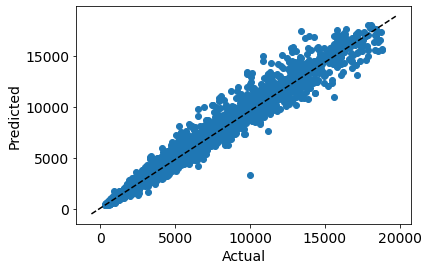

array([1188.94296176, 5890.77917546,  822.78581787, ..., 9322.20329577,
        645.22141316,  523.59825593])

In [53]:
best_rf = rf_random.best_estimator_
display_model("Random forest regressor",best_rf)

We can see here Random Forest Regression give us the best result so far with the lower mae,rmse and a r_squared of 99%

## Bagging Regression

In [54]:
# Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 6)]
# Maximum number of levels in tree
# Create the random grid
random_grid = {'n_estimators': n_estimators}
print(random_grid)

{'n_estimators': [1, 10, 20, 30, 40, 50]}


In [55]:
with tf.device('/device:GPU:0'):
    bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor())
    # Random search of parameters, using 2 fold cross validation, 
    # search across all combinations, and use all available cores
    bagging_random = RandomizedSearchCV(estimator = bagging, param_distributions = random_grid, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    bagging_random.fit(X_train, Y_train)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.0min finished


In [56]:
bagging_random.best_params_

{'n_estimators': 50}

Here, we see that bagging regressor work the best with the most number of estimators 50

====== Test Score ======
Rsquare: 0.991621
mae: 239.336950
rmse: 461.289393
====== Test Prediction vs Actual ======


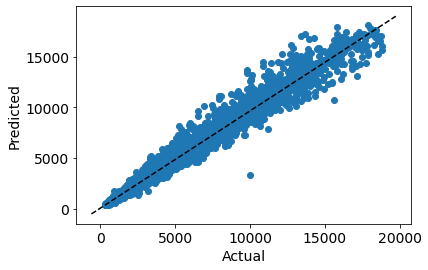

array([1211.29402852, 5952.9578795 ,  850.12723859, ..., 9297.71139305,
        655.21508194,  524.57632701])

In [57]:
best_bagging = bagging_random.best_estimator_
display_model("Bagging",best_bagging)

Bagging Regression work as well as random forest in our case.

## KNN

In [58]:
# Number of neighbors
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 20, num = 5)]
# Maximum number of levels in tree
# Create the random grid
random_grid = {'n_neighbors': n_neighbors}
print(random_grid)

{'n_neighbors': [1, 5, 10, 15, 20]}


In [59]:
with tf.device('/device:GPU:0'):
    knn = KNeighborsRegressor(weights='distance', metric='euclidean')
    # Random search of parameters, using 2 fold cross validation, 
    # search across all different combinations, and use all available cores
    knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    knn_random.fit(X_train, Y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [60]:
knn_random.best_params_

{'n_neighbors': 5}

We see that 1 is not the best choice for the parameter n_neighbors nor 10, 15 or 20. So, it is not true that the higher n_neighbors we set, the better result we have.

In fact, with n_neighbors = 1, we only consider one point, the nearest neighbor. With n_neighbors = 10, 15, 20 we take too much observations into account,which cannot bring useful information for our regression.

====== Test Score ======
Rsquare: 0.989067
mae: 259.923051
rmse: 506.376919
====== Test Prediction vs Actual ======


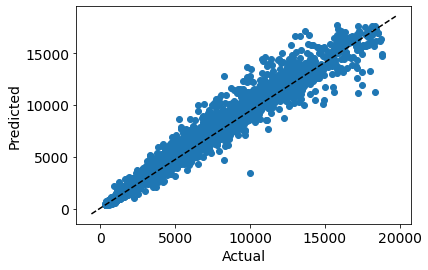

array([1195.92294368, 5918.28750669,  821.69378406, ..., 9312.69180996,
        624.62038184,  574.38454731])

In [61]:
best_knn = knn_random.best_estimator_
display_model("KNN",best_knn)

## Gradient Boosting

With gradient boosting, we know this algorithm resists pretty well with overfitting, so we just need to set a high number of estimators.

====== Test Score ======
Rsquare: 0.989009
mae: 278.222318
rmse: 518.683915
====== Test Prediction vs Actual ======


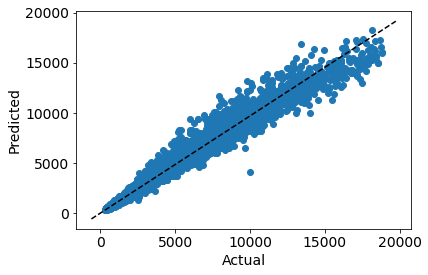

array([1066.42735124, 6158.0910194 ,  875.85226551, ..., 9862.90885514,
        692.1432436 ,  573.62381175])

In [62]:
grad_reg = GradientBoostingRegressor(n_estimators = 200)
display_model("Gradient boosting regressor",grad_reg)

## Comparisons

In [63]:
t  = PrettyTable(["Model","MAE","RMSE","R_square"])
for i in range(len(regressor)):
  t.add_row([regressor[i],round(mae_list[i],2),round(rmse_list[i],2),round(rsquare_list[i],4)])
print(t)

+---------------------------------+--------+---------+----------+
|              Model              |  MAE   |   RMSE  | R_square |
+---------------------------------+--------+---------+----------+
|       Regression Lineaire       | 349.45 |  632.64 |  0.9821  |
|         Ridge Regression        | 347.95 |  625.56 |  0.9817  |
| Polynomial regressor (degree 2) | 310.8  |  563.67 |  0.987   |
|     Decision tree regressor     | 315.73 |  614.76 |  0.9844  |
|       Ada boost regressor       | 675.57 | 1254.06 |  0.9454  |
|     Random forest regressor     | 237.64 |  457.7  |  0.9917  |
|             Bagging             | 239.34 |  461.29 |  0.9916  |
|               KNN               | 259.92 |  506.38 |  0.9891  |
|   Gradient boosting regressor   | 278.22 |  518.68 |  0.989   |
+---------------------------------+--------+---------+----------+


As we can see, we can reach a pretty good model with simple models like linear regressors, decision tree regressor (MAE $\sim$ 300, RMSE $\sim$ 600, R_squared $\sim$ 98%).

More complicated regressors like Random Forest Regressor, Bagging Regressor, KNN, Gradient Boosting work the best (MAE $\sim$ 200, RMSE $\sim$ 400, R_squared $\sim$ 99%).

AdaBoost Regressor have the worst score (MAE $\sim$ 675, RMSE $\sim$ 1254, R_squared $\sim$ 94.5%) while we saw in class that it's a advanced method (like we said before, maybe a decision tree with a depth of 3 is not sufficient to have good predictions).